In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymysql

### 连接SQL,取数据

In [2]:
#建立游标，读取数据
con=pymysql.connect(host='10.100.143.243',port=3310,user='std_risk4'\
                   ,passwd='GTDhG3p5',db='std_risk_analysis',charset='utf8')
cur=con.cursor()
cur.execute('select *,left(TIMEE,7) as TTIME from std_risk_analysis.hxg_ws_loan')

768357

In [3]:
#查看字段名称 并形成一个字段名的list
cur.description  
dat=list(cur.fetchall())
data_dict=[]
for field in cur.description:
    data_dict.append(field[0])
        
#形成数据框
data=pd.DataFrame(dat,columns=data_dict)
data.columns

Index(['CONTRACT_ID', 'num', 'application_id', 'transport_id', 'channel',
       'customer_name', 'flag_20to22', 'channel_rate_single', 'channel_rate',
       'applied_months', 'granted_month', 'lent_months', 'loan_id',
       'max_platform', 'TIMEE', 'balance', 'bal_corpus', 'CONTRACT_STATUS',
       'OVERDUE_STATES', 'flag_zhejiang', 'od30_n_plus', 'od30_bal_plus',
       'platform_import', 'platform_import_datadai', 'platform_import_new',
       'data_dai', 'platform_group', 'platform_single', 'loan_platform_group',
       'apr', 'amt_contract', 'initial_amount', 'cms_final_limit',
       'granted_amount_cents', 'amt_granted_bid', 'amt_granted_band',
       'amt_granted_LowCut', 'amt_granted_LowCut2', 'amt_release_band',
       'amt_contract_20wplus', 'amt_contract_8wplus', 'bal_corpus_8wplus',
       'max_active_days_band', 'gmv12_band', 'customer_seg', 'final_rate',
       'rate', 'transport_credit_type', 'decision_credit_type',
       'revolving_type_apply', 'revolving_type_grant

### 关键的KEY 联动后面的所有操作

In [4]:
###这步是关键！！！选择需要group by的变量
hxg_key=['final_rate_new']

### 形成基础表 并整合出base表grp1

In [5]:
dat=data.loc[(data.CONTRACT_STATUS == 1) | (data.CONTRACT_STATUS == 2)]
dat1=dat.copy()
dat1['cnt']=1
dat1['ENR_sum']=np.where(dat1.OVERDUE_STATES>=7,0,dat1.bal_corpus)
dat1['M2_P']=np.where(dat1.OVERDUE_STATES==2,dat1.bal_corpus,0)
dat1['M3_P']=np.where(dat1.OVERDUE_STATES==3,dat1.bal_corpus,0)
dat1['M4_P']=np.where(dat1.OVERDUE_STATES==4,dat1.bal_corpus,0)
dat1['M5_P']=np.where(dat1.OVERDUE_STATES==5,dat1.bal_corpus,0)
dat1['M6_P']=np.where(dat1.OVERDUE_STATES==6,dat1.bal_corpus,0)
dat1=dat1.loc[:,['cnt','bal_corpus','ENR_sum','M2_P','M3_P','M4_P','M5_P','M6_P','OVERDUE_STATES','TIMEE']+hxg_key]

In [6]:
##group by 操作
hxg_List=['OVERDUE_STATES','TIMEE']+hxg_key    ##此处可更换 group by 的类别
grp1=dat1.groupby(hxg_List,as_index=False).agg({'cnt':sum,'bal_corpus':sum,'ENR_sum':sum,\
                                                   'M2_P':sum,'M3_P':sum,'M4_P':sum,'M5_P':sum,'M6_P':sum})

In [7]:
##生成包含可追溯timee的df
from pandas.tseries.offsets import *
##构建一个计算月份差的函数
def getMonthDiff(dateStr,month):
    date = pd.to_datetime(dateStr)
    datediff = date - DateOffset(months=month)
    return datediff

tmpFunc = np.vectorize(lambda x,y: getMonthDiff(x,y))

od=grp1['OVERDUE_STATES']
ti=grp1['TIMEE']
grp1['TIMEE_C']=tmpFunc(ti,od)

##截取  年-月
def get_month(date):
    return(str(date)[0:7])

grp1['TIMEE_C_key']=ti=date=grp1['TIMEE_C'].apply(lambda x:get_month(x))
grp1['TIMEE_key']=ti=date=grp1['TIMEE'].apply(lambda x:get_month(x))
##明确 key
grp1['TIMEE_join_key']=grp1['TIMEE_C_key']

### 形成专用的TIMEE--bal的查询表grp2

In [8]:
##构造一个Lagged专用index 方便后续的查询
hxg_List2=['TIMEE_key']+hxg_key
grp2=grp1.groupby(hxg_List2,as_index=False).agg({'ENR_sum':sum})
##明确 key
grp2['TIMEE_join_key']=grp1['TIMEE_key']

### 形成最终形态 grp3

In [9]:
#形成group的结果
hxg_list3=['TIMEE_join_key']+hxg_key
grp3=pd.merge(grp1,grp2,on=hxg_list3,how='left')

In [10]:
grp3

,OVERDUE_STATES,TIMEE,final_rate_new,cnt,bal_corpus,ENR_sum_x,M2_P,M3_P,M4_P,M5_P,M6_P,TIMEE_C,TIMEE_C_key,TIMEE_key_x,TIMEE_join_key,TIMEE_key_y,ENR_sum_y
0,0,2015-01-31,Overseas_1,145,29141110.96,29141110.96,0,0,0,0,0,2015-01-31,2015-01,2015-01,2015-01,2015-01,29291110.96
1,0,2015-01-31,Overseas_2,2,150000.00,150000.00,0,0,0,0,0,2015-01-31,2015-01,2015-01,2015-01,2015-01,150000.00
2,0,2015-01-31,others,8,1128856.71,1128856.71,0,0,0,0,0,2015-01-31,2015-01,2015-01,2015-01,2015-01,1128856.71
3,0,2015-02-28,Overseas_1,152,29647623.56,29647623.56,0,0,0,0,0,2015-02-28,2015-02,2015-02,2015-02,2015-02,30393308.26
4,0,2015-02-28,Overseas_2,2,150000.00,150000.00,0,0,0,0,0,2015-02-28,2015-02,2015-02,2015-02,2015-02,160000.00
5,0,2015-02-28,others,12,1320000.00,1320000.00,0,0,0,0,0,2015-02-28,2015-02,2015-02,2015-02,2015-02,1618856.71
6,0,2015-03-31,Overseas_1,166,32967483.14,32967483.14,0,0,0,0,0,2015-03-31,2015-03,2015-03,2015-03,2015-03,33102031.58
7,0,2015-03-31,Overseas_2,2,127470.09,127470.09,0,0,0,0,0,2015-03-31,2015-03,2015-03,2015-03,2015-03,137470.09
8,0,2015-03-31,others,19,1546827.57,1546827.57,0,0,0,0,0,2015-03-31,2015-03,2015-03,2015-03,2015-03,1813845.74
9,0,2015-04-30,Domestic_ybp,66,6093741.62,6093741.62,0,0,0,0,0,2015-04-30,2015-04,2015-04,2015-04,2015-04,6093741.62


In [11]:
## 计算Lagged_M4+
grp3['la_4']=grp3['M4_P']/grp3['ENR_sum_y']
grp3['la_5']=grp3['M5_P']/grp3['ENR_sum_y']
grp3['la_6']=grp3['M6_P']/grp3['ENR_sum_y']
grp3['lagged_M4+']=grp3['la_4']+grp3['la_5']+grp3['la_6']

In [12]:
#形成数据 方便后续画图
grp_show=grp3.groupby(['TIMEE']+hxg_key,as_index=False).agg({'lagged_M4+':sum})

### 数据透视

In [13]:
#展示数据 便于观测
grp3.groupby(['TIMEE']+hxg_key).agg({'lagged_M4+':sum}).unstack()

lagged_M4+  \
final_rate_new                        Domestic_1   
TIMEE                                              
2015-01-31                                  None   
2015-02-28                                  None   
2015-03-31                                  None   
2015-04-30                                  None   
2015-05-31                                  0E+2   
2015-06-30                                  0E+2   
2015-07-31                                  0E+2   
2015-08-31                                  0E+2   
2015-09-30                                  0E+2   
2015-10-31                                  0E+2   
2015-11-30      0.006778780652294580789993743364   
2015-12-31       0.01400025980360257098417177242   
2016-01-31       0.02683946513771294764431008960   
2016-02-29       0.03107733323233724865706122112   
2016-03-31       0.03195109732759807039424405763   
2016-04-30       0.02980938004216185291835324877   
2016-05-31       0.02715768979266797397836330597   
2016-06-30       0.02798414882513154115409966016   
2016-07-31       0.02190356522345672123668294505   
2016-08-31       0.01904737166495104352272588285   
2016-09-30       0.01634646988487206182016607883   
2016-10-31       0.01669923224911775332398674729   
2016-11-30       0.01526381298221181293662721724   
2016-12-31       0.01489913290857225408939138055   
2017-01-31       0.01351264593155555708778399683   
2017-02-28       0.01412319624745146473014455622   
2017-03-31       0.01300859060142431930217093776   
2017-04-30       0.01632493788285070806347469078   
2017-05-31       0.01417910724309299016999085883   
2017-06-30       0.01212818275471475350885859712   
2017-07-31      0.009396782362977559749120454783   
2017-08-31      0.006547160176823109480230570306   
2017-09-30      0.005940185162982402965846838828   
2017-10-31      0.005467352800922395298709441104   
2017-11-30      0.004815449758973306442207361053   
2017-12-31      0.006489177618004800244047994126   
2018-01-31      0.008212406742142125049691444221   
2018-02-28       0.01323743284131048366311893056   
2018-03-31       0.01427546608966738233931477065   
2018-04-30       0.01767739231575861748051562679   
2018-05-31       0.01646233122716955090826847223   

                                                  \
final_rate_new                        Domestic_2   
TIMEE                                              
2015-01-31                                  None   
2015-02-28                                  None   
2015-03-31                                  None   
2015-04-30                                  None   
2015-05-31                                  None   
2015-06-30                                  None   
2015-07-31                                  None   
2015-08-31                                  0E+2   
2015-09-30                                  0E+2   
2015-10-31                                  0E+2   
2015-11-30                                  0E+2   
2015-12-31                                  0E+2   
2016-01-31                                  0E+2   
2016-02-29                                  0E+2   
2016-03-31      0.003769056524437863643455570557   
2016-04-30       0.01239046276393031695798220399   
2016-05-31      0.005535073081413212655777100617   
2016-06-30      0.008225071954148026377037390456   
2016-07-31      0.005763982451402705046310091204   
2016-08-31      0.007129524840378770026775106844   
2016-09-30      0.002911994720035214876865805733   
2016-10-31      0.003696617018352986891962784107   
2016-11-30      0.008636382350325260793945951135   
2016-12-31       0.01300961963789811852458996437   
2017-01-31       0.01229208357582793473000152772   
2017-02-28      0.009626667571865277339228078286   
2017-03-31      0.006849058936815411506294850937   
2017-04-30      0.009467846175910052493264167489   
2017-05-31       0.01313689105349387307133127890   
2017-06-30       0.01419078016969139340881279527   
2017-07-31       0.01245122984514

### matplotlib 作图

Text(0.5,1,'Lagged M4+')

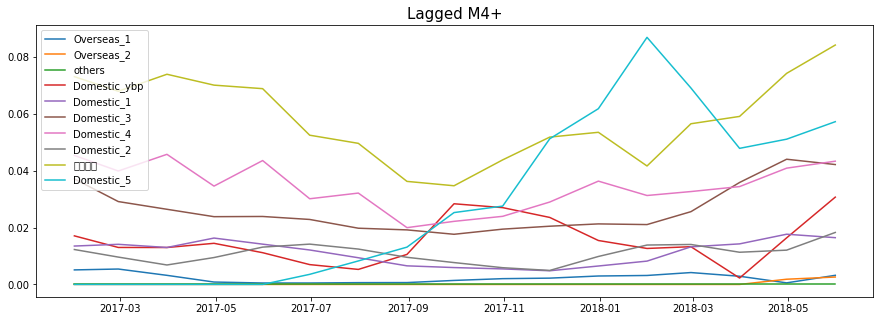

In [14]:
grp_show['TIMEE'] = pd.to_datetime(grp_show['TIMEE'],format='%Y-%m-%d %H:%M:%S')
grp_show=grp_show.loc[grp_show['TIMEE']>='2017-01-31']
##以上代码为限制展示时间节点

plt.figure(figsize=(15,5))
rate=grp3.drop_duplicates(subset=['final_rate_new'], keep='first', inplace=False).final_rate_new
for x in rate:
    plt.plot(grp_show.loc[grp_show.final_rate_new==x].TIMEE,grp_show.loc[grp_show.final_rate_new==x]['lagged_M4+'],'-')
    plt.legend(rate,loc='upper left')
plt.title('Lagged M4+',size=15)

In [15]:
### 关闭数据库库连接
con.commit()  
cur.close()  
con.close() 